In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import datetime as dt
import plotly
from sklearn import linear_model 
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
from subprocess import check_output

print(check_output(["ls", "/root/userspace/final/input"]).decode("utf8"))
import os
os.chdir('/root/userspace/final/input')


Using TensorFlow backend.


4307.csv
4307.jp.old.txt
4307.jp.old2.txt
4307.jp.txt
ivv.us.txt
qqq.us.txt



In [2]:
#Load the Data 
filename = '4307.jp.txt'
data = pd.read_csv(filename, sep=',')
label, _, _ = filename.split(sep='.')
data['Label'] = filename
data['Date'] = pd.to_datetime(data['Date'])

In [3]:
print(data)

           Date   Open   High    Low  Close   Volume  CloseAdjust        Label
0    2001-12-17  14850  14850  13800  14050  6566899        774.1  4307.jp.txt
1    2001-12-18  14000  14080  13810  13900  1358100        765.8  4307.jp.txt
2    2001-12-19  13890  14100  13420  13960   921800        769.2  4307.jp.txt
3    2001-12-20  14100  14290  13930  14230   533800        784.0  4307.jp.txt
4    2001-12-21  14300  14580  14100  14550   508000        801.7  4307.jp.txt
5    2001-12-25  14550  14550  14060  14100   140700        776.9  4307.jp.txt
6    2001-12-26  14300  14940  14200  14890   416300        820.4  4307.jp.txt
7    2001-12-27  15090  15490  15060  15320   835900        844.1  4307.jp.txt
8    2001-12-28  15500  15520  15310  15380   229200        847.4  4307.jp.txt
9    2002-01-04  15580  15620  15100  15310   168800        843.5  4307.jp.txt
10   2002-01-07  15490  16130  15390  15900   585500        876.0  4307.jp.txt
11   2002-01-08  15990  16540  15910  16080   718700

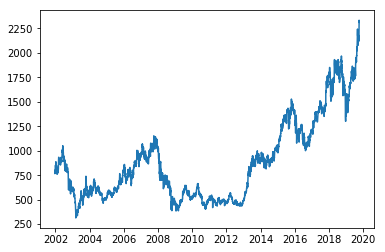

In [5]:
#Close Price adjusted
data = data.sort_values('Date')
label = data['Label'].iloc[0]
plt.plot(data['Date'], data['CloseAdjust'], label="NRI")

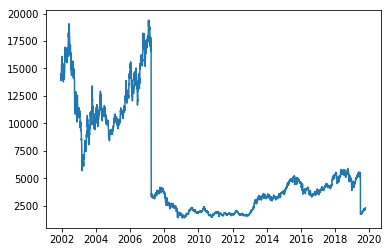

In [6]:
#Close Price not be adjusted
data = data.sort_values('Date')
label = data['Label'].iloc[0]
plt.plot(data['Date'], data['Close'], label="ETF")

In [7]:
##Creating windows and normalizing the data

window_len = 10

#Create a data point (i.e. a date) which splits the training and testing set
split_date = list(data["Date"][-(2*window_len+1):])[0]

#Split the training and test set
training_set, test_set = data[data['Date'] < split_date], data[data['Date'] >= split_date]
training_set = training_set.drop(['Date','Label', 'Close'], 1)
test_set = test_set.drop(['Date','Label','Close'], 1)

#Create windows for training
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    
    for col in list(temp_set):
        temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1
    
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['CloseAdjust'][window_len:].values/training_set['CloseAdjust'][:-window_len].values)-1

LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

#Create windows for testing
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    
    for col in list(temp_set):
        temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1
    
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['CloseAdjust'][window_len:].values/test_set['CloseAdjust'][:-window_len].values)-1

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [8]:
print(test_set)

      Open  High   Low   Volume  CloseAdjust
4345  2215  2222  2158  2775300       2166.0
4346  2125  2125  2072  4456800       2077.0
4347  2054  2110  2015  3430000       2082.0
4348  2074  2091  2050  2500700       2086.0
4349  2092  2104  2067  2111000       2080.0
4350  2097  2100  2061  2490000       2086.0
4351  2110  2133  2095  2148600       2114.0
4352  2117  2140  2086  4269900       2114.0
4353  2117  2157  2108  1885400       2116.0
4354  2115  2171  2115  2270400       2162.0
4355  2202  2232  2174  2247700       2183.0
4356  2200  2200  2131  1377500       2163.0
4357  2154  2167  2137  1391600       2151.0
4358  2135  2155  2103  1393200       2118.0
4359  2111  2132  2107  1484900       2124.0
4360  2100  2143  2093  1559100       2135.0
4361  2160  2192  2151  1824400       2187.0
4362  2197  2204  2181  1376700       2197.0
4363  2208  2252  2193  2345300       2251.0
4364  2253  2333  2251  3047300       2332.0
4365  2330  2337  2280  2673700       2311.0


In [9]:
#LSTM model definition
def build_model(inputs, output_size, neurons, activ_func="linear", dropout=0.20, loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [10]:
##Training of the LSTM model

# initialise model architecture
nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, epochs=5, batch_size=1, verbose=2, shuffle=True)

Epoch 1/5
 - 75s - loss: 0.0254
Epoch 2/5
 - 71s - loss: 0.0189
Epoch 3/5
 - 71s - loss: 0.0179
Epoch 4/5
 - 71s - loss: 0.0177
Epoch 5/5
 - 71s - loss: 0.0175


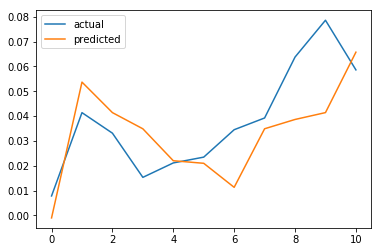

The Mean Absolute Error is: 0.013581232608433448


In [11]:
#Plot of prediction of one data point ahead
#As can be seen in the plot, one step prediction is not bad. The scale is a bit of, because the data is normalized.

plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
plt.legend()
plt.show()
MAE = mean_absolute_error(LSTM_test_outputs, nn_model.predict(LSTM_test_inputs))
print('The Mean Absolute Error is: {}'.format(MAE))

In [12]:
print(LSTM_test_outputs)

[0.00784857 0.04140587 0.03314121 0.01534036 0.02115385 0.02348993
 0.03453169 0.03926206 0.06379962 0.0786309  0.05863491]


In [ ]:
#Reference1: https://www.kaggle.com/johanvandenheuvel/lstm-model-of-stockdata
#Reference2: https://github.com/llSourcell/How-to-Predict-Stock-Prices-Easily-Demo/blob/master/lstm.py